<a href="https://colab.research.google.com/github/hamzarabi3/DataSciencePortfolio/blob/master/concrete_cracks_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction


this notebook was inspired by a course offered by IBM on coursera. In this notebook, you will build an image classifier using the VGG16 and ResNet50 pre-trained models, I added the a classification layer on top of each of them and trained that additional layer weights using colab GPU.

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>    

1. <a href="#item41">Download Data 
2. <a href="#item42">VGG16</a>
3. <a href="#item43">RESNET50</a>  
4. <a href="#item44">COMPARISON AND PREDICTIONS</a>  

</font>
    
</div>

## Download Data

In [0]:
! wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/concrete_data_week4.zip

--2020-05-18 17:18:21--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/concrete_data_week4.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261483817 (249M) [application/zip]
Saving to: ‘concrete_data_week4.zip’

concrete_data_week4 100%[===================>] 249.37M  20.5MB/s    in 13s     

2020-05-18 17:18:36 (18.5 MB/s) - ‘concrete_data_week4.zip’ saved [261483817/261483817]



In [0]:
! unzip concrete_data_week4.zip

**Global imports and setup**

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

>Because the dataset is too large to be loaded entirely in RAM we are going to use the `ImageDataGenerator` Class, this latter will load only limited size batches (`batch_size_validation` & `batch_size_training`) of data as required by the model. we will create two Genereator pipelines by impelementing the `flow_from_directory()` method. 

In [0]:
num_classes = 2
image_resize = 224
batch_size_training = 100
batch_size_validation = 100
train_dir='/content/concrete_data_week4/train'
valid_dir='/content/concrete_data_week4/valid'
data_generator=ImageDataGenerator(preprocessing_function=preprocess_input)

In [0]:
train_gen= gen.flow_from_directory(
    train_dir,
    target_size=(image_resize,image_resize),
    batch_size=batch_size_training,
)
valid_gen=gen.flow_from_directory(
    valid_dir,
    target_size=(image_resize,image_resize),
    batch_size=batch_size_validation
)

Found 30001 images belonging to 2 classes.
Found 9501 images belonging to 2 classes.


>Checking the GPU.

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## VGG16

>So here we add our VGG16 tained model as input layer, set that layer to be non-trainable, and then we add our output layer with two units and Softmax activation, since we are doing classification.

In [0]:
vgg=Sequential()
vgg.add(VGG16(
    include_top=False,
    pooling='avg',
    weights='imagenet'
    ))
vgg.add(Dense(2,activation='softmax'))
vgg.layers[0].trainable=False
vgg.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
vgg.summary()

58892288/58889256 [==============================] - 6s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1026      
Total params: 14,715,714
Trainable params: 1,026
Non-trainable params: 14,714,688
_________________________________________________________________


>Training the output layer parameters using the generator we defined earlier.

In [0]:
steps_per_epoch_training = len(train_gen)
steps_per_epoch_validation = len(valid_gen)
num_epochs = 10

with tf.device('/device:GPU:0'):  
    vgg_hisotry=vgg.fit_generator(
      train_gen,
      steps_per_epoch=steps_per_epoch_training,
      epochs=num_epochs,
      validation_data=valid_gen,
      validation_steps=steps_per_epoch_validation,
      verbose=1
       )

Epoch 1/10
301/301 [==============================] - 372s 1s/step - loss: 0.0325 - accuracy: 0.9920 - val_loss: 0.0061 - val_accuracy: 0.9935
Epoch 2/10
301/301 [==============================] - 373s 1s/step - loss: 0.0225 - accuracy: 0.9940 - val_loss: 0.0027 - val_accuracy: 0.9949
Epoch 3/10
301/301 [==============================] - 371s 1s/step - loss: 0.0178 - accuracy: 0.9951 - val_loss: 9.5959e-05 - val_accuracy: 0.9957
Epoch 4/10
301/301 [==============================] - 372s 1s/step - loss: 0.0148 - accuracy: 0.9958 - val_loss: 3.5101e-04 - val_accuracy: 0.9963
Epoch 5/10
301/301 [==============================] - 372s 1s/step - loss: 0.0129 - accuracy: 0.9968 - val_loss: 5.9605e-07 - val_accuracy: 0.9960
Epoch 6/10
301/301 [==============================] - 371s 1s/step - loss: 0.0115 - accuracy: 0.9970 - val_loss: 0.0032 - val_accuracy: 0.9965
Epoch 7/10
301/301 [==============================] - 371s 1s/step - loss: 0.0102 - accuracy: 0.9973 - val_loss: 0.0000e+00 - val_

In [0]:
vgg.save('/content/drive/My Drive/Models/myvgg.h5')

## RESNET50

>Same thing again with RESNET50

In [0]:
resnet=Sequential()
resnet.add(ResNet50(    
    include_top=False,
    pooling='avg',
    weights='imagenet')
)
resnet.add(Dense(2,activation='softmax'))
resnet.layers[0].trainable=False
resnet.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
resnet.summary()

94658560/94653016 [==============================] - 8s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


In [0]:
with tf.device('/device:GPU:0'):
      resnet_hisotry=resnet.fit_generator(
        train_gen,
        steps_per_epoch=steps_per_epoch_training,
        epochs=num_epochs,
        validation_data=valid_gen,
        validation_steps=steps_per_epoch_validation,
        verbose=1
                  )
resnet.save('/content/drive/My Drive/Models/myresnet50.h5')

Epoch 1/10
301/301 [==============================] - 374s 1s/step - loss: 0.0476 - accuracy: 0.9848 - val_loss: 0.6026 - val_accuracy: 0.5964
Epoch 2/10
301/301 [==============================] - 366s 1s/step - loss: 0.0144 - accuracy: 0.9960 - val_loss: 4.8994e-05 - val_accuracy: 0.6568
Epoch 3/10
301/301 [==============================] - 365s 1s/step - loss: 0.0092 - accuracy: 0.9979 - val_loss: 3.0044 - val_accuracy: 0.6814
Epoch 4/10
301/301 [==============================] - 365s 1s/step - loss: 0.0192 - accuracy: 0.9949 - val_loss: 1.0896 - val_accuracy: 0.7090
Epoch 5/10
301/301 [==============================] - 365s 1s/step - loss: 0.0126 - accuracy: 0.9964 - val_loss: 0.8401 - val_accuracy: 0.7471
Epoch 6/10
301/301 [==============================] - 365s 1s/step - loss: 0.0160 - accuracy: 0.9956 - val_loss: 2.0742e-05 - val_accuracy: 0.7171
Epoch 7/10
301/301 [==============================] - 364s 1s/step - loss: 0.0110 - accuracy: 0.9971 - val_loss: 2.9087e-05 - val_accu

<a id="item44"></a>

## COMPARISON AND PREDICTIONS

>Lets create another generator pipline for the test directory. but this time since the data set is small and we will be using this generator for predictions, I set the `batch_size` to 1. 

In [0]:
test_dir='/content/concrete_data_week4/test'
test_gen=gen.flow_from_directory(
    test_dir,
    target_size=(image_resize,image_resize),
    shuffle=False,
    batch_size=1
)

Found 500 images belonging to 2 classes.


>Evaluate on the test set 

In [0]:
resnet50_score=resnet.evaluate_generator(test_gen)
vgg_score=vgg.evaluate_generator(test_gen)

In [0]:
print(f'resnet50 model scored : {resnet50_score}')
print(f'vgg model scored : {vgg_score}')

resnet50 model scored : [3.3071391582489014, 0.7260000109672546]
vgg model scored : [2.50339189733495e-06, 0.9959999918937683]


>VGG is doing very well <br>
>Now let's generate some predictions for the first 10 images. 

In [0]:
results=resnet.predict_generator(test_gen,steps=10)
i=-1
for x in results:
  i+=1
  if x[0]<x[1]:
    print(f'RESNET50 says image number {i} shows a crack')
  elif x[0]>x[1]:
    print(f'RESNET50 says image number {i} does not show a crack')

RESNET50 says image number 0 does not show a crack
RESNET50 says image number 1 does not show a crack
RESNET50 says image number 2 does not show a crack
RESNET50 says image number 3 does not show a crack
RESNET50 says image number 4 does not show a crack
RESNET50 says image number 5 does not show a crack
RESNET50 says image number 6 does not show a crack
RESNET50 says image number 7 does not show a crack
RESNET50 says image number 8 does not show a crack
RESNET50 says image number 9 does not show a crack


In [0]:
results=vgg.predict_generator(test_gen,steps=10)
i=-1
for x in results:
  i+=1
  if x[0]<x[1]:
    print(f'VGG16 says image number {i} shows a crack')
  elif x[0]>x[1]:
    print(f'VGG16 says image number {i} does not show a crack')

VGG16 says image number 0 does not show a crack
VGG16 says image number 1 does not show a crack
VGG16 says image number 2 does not show a crack
VGG16 says image number 3 does not show a crack
VGG16 says image number 4 does not show a crack
VGG16 says image number 5 does not show a crack
VGG16 says image number 6 does not show a crack
VGG16 says image number 7 does not show a crack
VGG16 says image number 8 does not show a crack
VGG16 says image number 9 does not show a crack


**Ok, Let me see!**

In [0]:
images=[]
for i in range(10):
  images.append(test_gen.next())

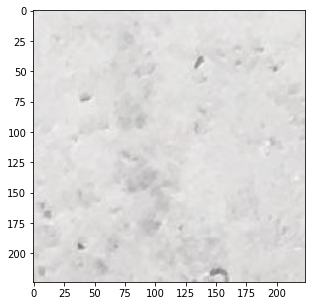

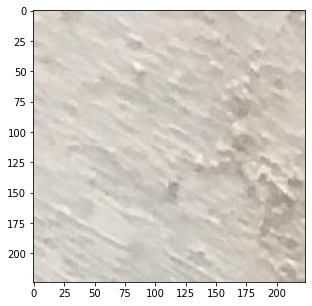

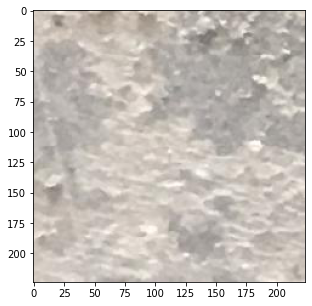

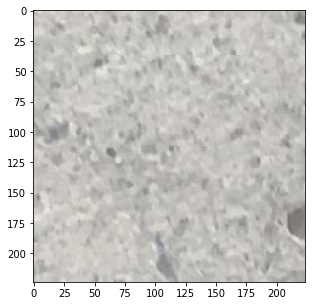

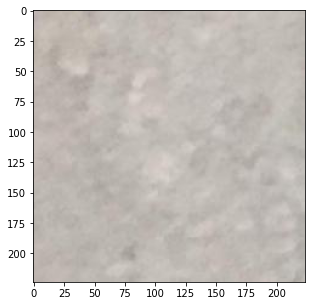

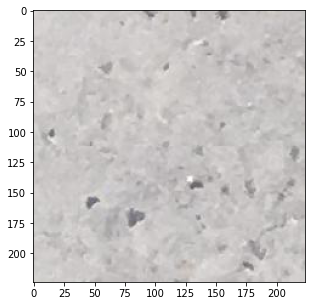

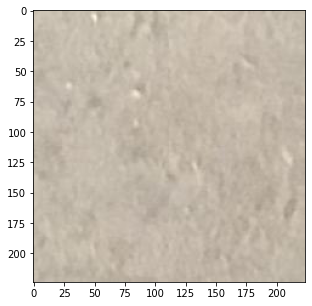

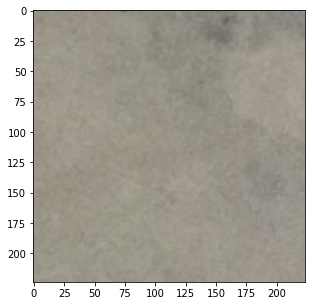

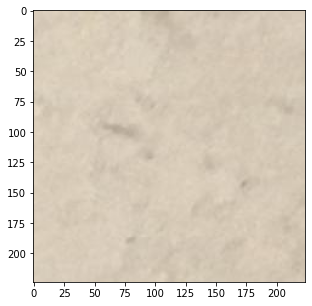

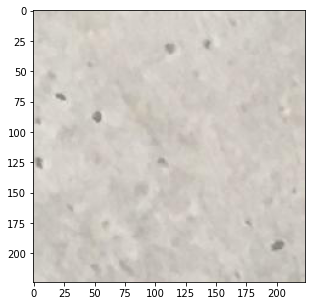

In [0]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize']=10, 5
for i in range(10):
  image=images[i]
  image=image[0].reshape(224,224,3)/255.0
  plt.imshow(image);
  plt.show()

>OK, that look pretty accurate

## Done by [Hamza Rabi](https://www.linkedin.com/in/hamza-rabi/)